In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from termcolor import colored
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
class Logistic_Regression():
    def __init__(self, input_channels, output_channels, epochs, lr, loss_weight=None):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.epochs = epochs
        self.lr = lr
        self.loss_his = []
        self.weights = np.random.rand(input_channels * output_channels,1)
        self.bias = np.random.rand(1)[0]
        self.loss_weight = loss_weight

    def __loss(self, y, y_pred):
        if self.loss_weight is None:
            return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1-y_pred))
        else:
            return -np.mean(3.5 * y * np.log(y_pred) + (1 - y) * np.log(1-y_pred))
            # return - self.loss_weight * np.mean(y * np.log(y_pred)) - (1 - self.loss_weight) * np.mean((1 - y) * np.log(1-y_pred))
            
    def __sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def __gradient(self, x, y, y_pred):
        m = x.shape[0]

        dw = np.dot(x.T, y_pred-y) / m
        db = np.sum(y_pred-y) / m

        return dw, db

    def predict_prob(self, x):
        return self.__sigmoid(np.dot(x, self.weights) + self.bias)

    def fit(self, X, y):
        loop = tqdm(range(self.epochs))
        for _ in loop:
            pred = self.predict_prob(X)
            loss = self.__loss(y, pred)
            self.loss_his.append(loss)

            dw, db = self.__gradient(X, y, pred)
            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db

            loop.set_description("Training Proceed")
            loop.set_postfix(loss=loss)

    def plot_loss(self):
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(self.loss_his)
        plt.show()

    def predict(self, x, threshold=0.5):
        y_pred = self.predict_prob(x)
        y_pred = y_pred >= threshold
        y_pred = y_pred.astype('int')
        return y_pred

    def evaluate(self, x, y):
        print(colored("\nEvaluate on Test Set:\n", "blue"))
        y_pred = self.predict(x)
        print(colored(f"\tAccuracy: {accuracy_score(y, y_pred):.3f}", "yellow"))
        print(colored(f"\tPrecision: {precision_score(y, y_pred):.3f}", "yellow"))
        print(colored(f"\tRecall: {recall_score(y, y_pred):.3f}", "yellow"))
        print(colored(f"\tF1-score: {f1_score(y, y_pred):.3f}", "yellow"))

        confusion_m = confusion_matrix(y, y_pred)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_m, display_labels = [False, True])
        print(colored("\nDisplay Confusion Matrix:\n", "blue"))
        cm_display.plot()
        plt.show()

In [3]:
df = pd.read_csv("./heart.csv")
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


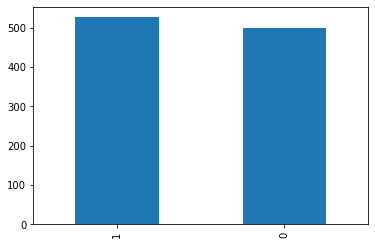

In [4]:
df['target'].value_counts().plot.bar()
plt.show()

In [5]:
df.shape

(1025, 14)

In [6]:
scaler = StandardScaler()
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
contiuous_features  = [feature for feature in df.columns.values if feature not in categorical_features]
contiuous_features.remove('target')

In [7]:
print(f"Unique value of sex: {df.sex.unique()}")
print(f"Unique value of cp: {df.cp.unique()}")
print(f"Unique value of fbs: {df.fbs.unique()}")
print(f"Unique value of restecg: {df.restecg.unique()}")
print(f"Unique value of exang: {df.exang.unique()}")
print(f"Unique value of slope: {df.slope.unique()}")
print(f"Unique value of ca: {df.ca.unique()}")
print(f"Unique value of thal: {df.thal.unique()}")

Unique value of sex: [1 0]
Unique value of cp: [0 1 2 3]
Unique value of fbs: [0 1]
Unique value of restecg: [1 0 2]
Unique value of exang: [0 1]
Unique value of slope: [2 0 1]
Unique value of ca: [2 0 1 3 4]
Unique value of thal: [3 2 1 0]


# Preprocessing data

In [8]:
train_ratio = 0.7
df_label_1 = df[df["target"] == 1]
X_label_1_continuous = scaler.fit_transform(df_label_1[contiuous_features].values)
X_label_1_categorical = df_label_1[categorical_features].values
X_label_1 = np.concatenate((X_label_1_continuous, X_label_1_categorical), axis=1)
X_label_1_train = X_label_1[:int(X_label_1.shape[0] * train_ratio), :]
print(f"Number of label 1 in train set: {X_label_1_train.shape[0]}")
X_label_1_test = X_label_1[int(X_label_1.shape[0] * train_ratio):, :]
print(f"Number of label 1 in test set: {X_label_1_test.shape[0]}")
assert X_label_1_train.shape[0] !=  X_label_1_test.shape[0], "Split train-test have problem"
assert X_label_1_train.shape[0] + X_label_1_test.shape[0] == X_label_1.shape[0], "Sum of samples from train-test set wrong!"

df_label_0 = df[df["target"] == 0]
X_label_0_continuous = scaler.fit_transform(df_label_0[contiuous_features].values)
X_label_0_categorical = df_label_0[categorical_features].values
X_label_0 = np.concatenate((X_label_0_continuous, X_label_0_categorical), axis=1)
X_label_0_train = X_label_0[:int(X_label_0.shape[0] * train_ratio), :]
print(f"Number of label 0 in train set: {X_label_0_train.shape[0]}")
X_label_0_test = X_label_0[int(X_label_0.shape[0] * train_ratio):, :]
print(f"Number of label 0 in test set: {X_label_0_test.shape[0]}")
assert X_label_0_train.shape[0] !=  X_label_0_test.shape[0], "Split train-test have problem"
assert X_label_0_train.shape[0] + X_label_0_test.shape[0] == X_label_0.shape[0], "Sum of samples from train-test set wrong!"

Number of label 1 in train set: 368
Number of label 1 in test set: 158
Number of label 0 in train set: 349
Number of label 0 in test set: 150


# Train - Test

X_train shape: (717, 13)
y_train shape: (717, 1)
X_test shape: (308, 13)
y_test shape: (308, 1)


Training Proceed: 100%|██████████| 1000/1000 [00:08<00:00, 117.44it/s, loss=0.331]


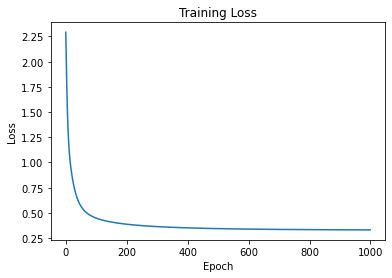


Evaluate on Test Set:

	Accuracy: 0.815
	Precision: 0.826
	Recall: 0.810
	F1-score: 0.818

Display Confusion Matrix:



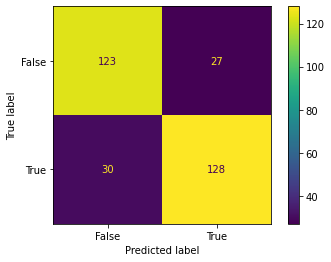

In [9]:
X_train_base = np.concatenate((X_label_1_train, X_label_0_train), axis=0)
y_train_base = np.expand_dims(np.array([1] * X_label_1_train.shape[0] + [0] * X_label_0_train.shape[0]), axis=1)
data_train_base = np.concatenate((X_train_base, y_train_base), axis=1)
data_train_base = shuffle(data_train_base)
X_train_base = data_train_base[:, :-1]
y_train_base = np.expand_dims(data_train_base[:, -1], axis=1)

X_test_base = np.concatenate((X_label_1_test, X_label_0_test), axis=0)
y_test_base = np.expand_dims(np.array([1] * X_label_1_test.shape[0] + [0] * X_label_0_test.shape[0]), axis=1)
data_test_base = np.concatenate((X_test_base, y_test_base), axis=1)
data_test_base = shuffle(data_test_base)
X_test_base = data_test_base[:, :-1]
y_test_base = np.expand_dims(data_test_base[:, -1], axis=1)

print(f"X_train shape: {X_train_base.shape}")
print(f"y_train shape: {y_train_base.shape}")
print(f"X_test shape: {X_test_base.shape}")
print(f"y_test shape: {y_test_base.shape}")

np.random.seed(42)
model = Logistic_Regression(13, 1, 1000, 0.09)
model.fit(X_train_base, y_train_base)
model.plot_loss()
model.evaluate(X_test_base, y_test_base)

X_train shape: (449, 13)
y_train shape: (449, 1)
X_test shape: (308, 13)
y_test shape: (308, 1)


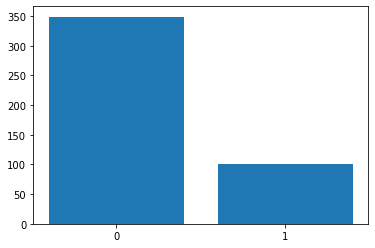

In [10]:
X_label_1_train_100_samples = X_label_1_train[:100, :]
X_train_100_samples = np.concatenate((X_label_1_train_100_samples, X_label_0_train), axis=0)
y_train_100_samples = np.expand_dims(np.array([1] * X_label_1_train_100_samples.shape[0] + [0] * X_label_0_train.shape[0]), axis=1)
data_train_100_samples = np.concatenate((X_train_100_samples, y_train_100_samples), axis=1)
data_train_100_samples = shuffle(data_train_100_samples)
X_train_100_samples = data_train_100_samples[:, :-1]
y_train_100_samples = np.expand_dims(data_train_100_samples[:, -1], axis=1)

print(f"X_train shape: {X_train_100_samples.shape}")
print(f"y_train shape: {y_train_100_samples.shape}")
print(f"X_test shape: {X_test_base.shape}")
print(f"y_test shape: {y_test_base.shape}")

plt.bar(["0", "1"], [X_label_0_train.shape[0], X_label_1_train_100_samples.shape[0]])
plt.show()

Training Proceed: 100%|██████████| 1000/1000 [00:04<00:00, 219.69it/s, loss=0.254]


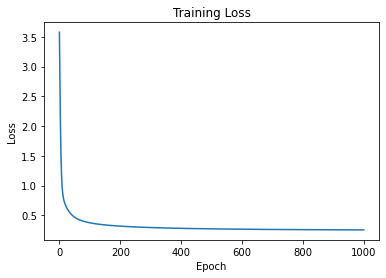


Evaluate on Test Set:

	Accuracy: 0.782
	Precision: 0.917
	Recall: 0.633
	F1-score: 0.749

Display Confusion Matrix:



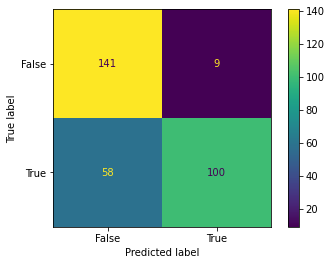

In [11]:
np.random.seed(42)
model2 = Logistic_Regression(13, 1, 1000, 0.09)
model2.fit(X_train_100_samples, y_train_100_samples)
model2.plot_loss()
model2.evaluate(X_test_base, y_test_base)

Training Proceed: 100%|██████████| 3000/3000 [00:12<00:00, 231.30it/s, loss=0.604]


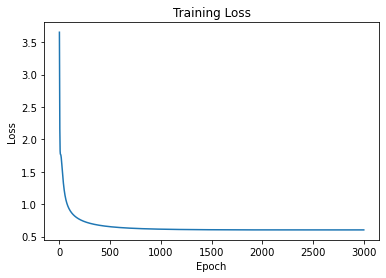


Evaluate on Test Set:

	Accuracy: 0.795
	Precision: 0.920
	Recall: 0.658
	F1-score: 0.768

Display Confusion Matrix:



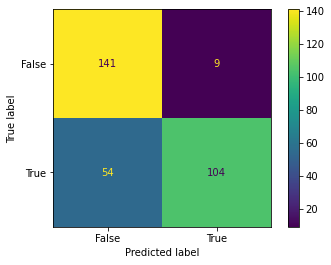

In [12]:
np.random.seed(42)
model3 = Logistic_Regression(13, 1, 3000, 0.09, 0.3)
model3.fit(X_train_100_samples, y_train_100_samples)
model3.plot_loss()
model3.evaluate(X_test_base, y_test_base)